<a href="https://colab.research.google.com/github/t1seo/TotochTeam2/blob/main/Day2/%EC%9D%B4%EC%9B%83%EC%A7%91_%ED%86%A0%ED%86%A0%EC%B9%98_Day2_%EC%8B%A4%EC%8A%B5%EC%98%88%EC%A0%9C(%EC%84%9C%ED%83%9C%EC%9B%90).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이웃집 토토치 파이토치 : Day 2
---

해당 게시물은 파이토치 공식 튜토리얼 중 [예제로 배우는 파이토치(PYTORCH)](https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html#pytorch)와 [TORCH.NN 이 실제로 무엇인가요?](https://tutorials.pytorch.kr/beginner/nn_tutorial.html?highlight=mnist) 그리고 ['김승환'님의 블로그](https://velog.io/@hwanython/%EC%8B%A0%EA%B2%BD%EB%A7%9D-%EB%84%98%ED%8C%8C%EC%9D%B4%EB%A1%9C-%EB%A7%8C%EB%93%A4%EC%96%B4-%EB%B3%B4%EA%B8%B0)를 토대로 작성되었습니다.

### 주요키워드
- Tensor
- Autograd
- Transform
- Torch.nn

### 목차


1.   Numpy로 시작하는 MNIST  
    (1) MNIST 데이터 준비  
    (2) Numpy로 MNIST분류기
2.   Pytorch로 구현하는 MNIST 손글씨 분류기






## 1. Numpy로 시작하는 MNIST
---
파이토치를 처음 배우는 입장에서 코드를 처음부터 직접 코드를 짜는 것은 매우 어려운 일에 속합니다.  
파이토치 코드의 이해를 좀 더 돕기위해 Numpy로 구현 된 MNIST분류기의 코드를 하나하나 바꿔가면서 파이토치 함수들의 이해를 돕고 차후에 프로젝트를 진행할 때에 좀 더 수월할 수 있도록 아래와 같이 실습을 진행하겠습니다.

### (1) MNIST 데이터 준비
전체 실습과정에서 우리는 손으로 쓴 숫자(0에서 9 사이)의 흑백 이미지로 구성된 클래식
[MNIST](http://deeplearning.net/data/mnist/) 데이터셋을 사용할 것 입니다.

우리는 경로 설정을 담당하는 (Python3 표준 라이브러리의 일부인)
[pathlib](https://docs.python.org/3/library/pathlib.html) 을 사용할 것이고,
[requests](http://docs.python-requests.org/en/master/) 를 이용하여
데이터셋을 다운로드 할 것입니다. 우리는 모듈을 사용할 때만 임포트(import) 할 것이므로,
여러분은 매 포인트마다 정확히 어떤 것이 사용되는지 확인할 수 있습니다.

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


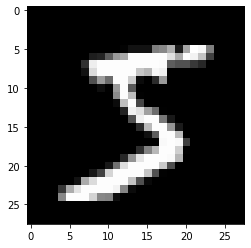

In [3]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [4]:
y_train[0]

5

In [5]:
y_train.shape

(50000,)

(10000, 784)


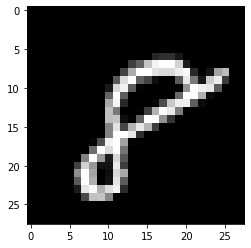

In [6]:
plt.imshow(x_valid[9999].reshape((28, 28)), cmap="gray")
print(x_valid.shape)

In [7]:
print(x_train, y_train)
print(x_train.shape)
print(x_valid.shape)
print(type(x_train))
print(y_train.min(), y_train.max())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [5 0 4 ... 8 4 8]
(50000, 784)
(10000, 784)
<class 'numpy.ndarray'>
0 9


총 6000개의 데이터셋을 불러오는데 성공하였습니다.  
그럼 이제 Numpy코드로만 MNIST 분류기를 구현하겠습니다.

### (2) Numpy로 구현한 MNIST분류기
---

In [8]:
weight_init_std = 0.1
input_size = 784
hidden_size = 256
output_size = 10

In [9]:
def affine_layer_forward(X, W, b):
    y = np.dot(X, W) + b
    cache = (X, W, b)
    return y, cache

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

In [11]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [12]:
def _change_one_hot_label(X, num_category):
    T = np.zeros((X.size, num_category))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

In [13]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

In [14]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [15]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    return W1, b1, W2, b2

In [16]:
def affine_layer_backward(dy, cache):
    X, W, b = cache
    dX = np.dot(dy, W.T)
    dW = np.dot(X.T, dy)
    db = np.sum(dy, axis=0)
    return dX, dW, db

In [17]:
def predict(W1, b1, W2, b2, X):
    a1 = np.dot(X, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

In [18]:
def accuracy(W1, b1, W2, b2, x, y):
    y_hat = predict(W1, b1, W2, b2, x)
    y_hat = np.argmax(y_hat, axis=1)

    accuracy = np.sum(y_hat == y) / float(x.shape[0])
    return accuracy

In [19]:
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

def train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=False):
    a1, cache1 = affine_layer_forward(X, W1, b1)
    z1 = sigmoid(a1)
    a2, cache2 = affine_layer_forward(z1, W2, b2)
    y_hat = softmax(a2)
    t = _change_one_hot_label(Y, 10)
    Loss = cross_entropy_error(y_hat, t)

    if verbose:
        print('---------')
        print(y_hat)
        print(t)
        print('Loss: ', Loss)
        
    dy = (y_hat - t) / X.shape[0]
    dz1, dW2, db2 = affine_layer_backward(dy, cache2)
    da1 = sigmoid_grad(a1) * dz1
    dX, dW1, db1 = affine_layer_backward(da1, cache1)
    
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    return W1, b1, W2, b2, Loss

In [20]:
def init_params(input_size, hidden_size, output_size, weight_init_std=0.01):

    W1 = weight_init_std * np.random.randn(input_size, hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = weight_init_std * np.random.randn(hidden_size, output_size)
    b2 = np.zeros(output_size)

    print(W1.shape)
    print(b1.shape)
    print(W2.shape)
    print(b2.shape)
    
    return W1, b1, W2, b2

In [21]:
# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
valid_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

W1, b1, W2, b2 = init_params(784, 256, 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    W1, b1, W2, b2, Loss = train_step(x_batch, y_batch, W1, b1, W2, b2, learning_rate=0.1, verbose=False)

    # 학습 경과 기록
    train_loss_list.append(Loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        print(i)
        print(f'Train Loss: {Loss:.4f}')
        train_acc = accuracy(W1, b1, W2, b2, x_train, y_train)
        valid_acc = accuracy(W1, b1, W2, b2, x_valid, y_valid)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        print(f'Train acc : {train_acc:.2f} \nValid acc : {valid_acc:.2f}')

print(f'final Train acc : {train_acc:.2f} \nfinal Valid acc : {valid_acc:.2f}')

(784, 256)
(256,)
(256, 10)
(10,)
0
Train Loss: 2.3068
Train acc : 0.10 
Valid acc : 0.10
500
Train Loss: 0.6920
Train acc : 0.80 
Valid acc : 0.82
1000
Train Loss: 0.3461
Train acc : 0.88 
Valid acc : 0.89
1500
Train Loss: 0.3042
Train acc : 0.89 
Valid acc : 0.90
2000
Train Loss: 0.3770
Train acc : 0.90 
Valid acc : 0.91
2500
Train Loss: 0.3199
Train acc : 0.91 
Valid acc : 0.91
3000
Train Loss: 0.3485
Train acc : 0.91 
Valid acc : 0.92
3500
Train Loss: 0.2410
Train acc : 0.91 
Valid acc : 0.92
4000
Train Loss: 0.3113
Train acc : 0.92 
Valid acc : 0.92
4500
Train Loss: 0.2816
Train acc : 0.92 
Valid acc : 0.92
5000
Train Loss: 0.2719
Train acc : 0.92 
Valid acc : 0.93
5500
Train Loss: 0.1236
Train acc : 0.92 
Valid acc : 0.93
6000
Train Loss: 0.4025
Train acc : 0.93 
Valid acc : 0.93
6500
Train Loss: 0.2089
Train acc : 0.93 
Valid acc : 0.93
7000
Train Loss: 0.1914
Train acc : 0.93 
Valid acc : 0.93
7500
Train Loss: 0.2994
Train acc : 0.93 
Valid acc : 0.94
8000
Train Loss: 0.2789
Tr

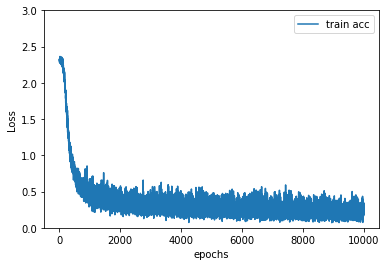

In [22]:
# Loss 그래프 그리기
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.ylim(0, 3.0)
plt.legend(loc='best')
plt.show()

Numpy로만 MNIST손글씨 분류기를 만들어 보았습니다.  
총 10000번의 반복문을 돌리면서 최종 94%의 Accuracy를 달성하였습니다.  
Numpy로 구현한 모델은 아래 그림과 같은 구조를 가지고 있습니다.  
이제 아래의 구조를 Pytorch로 구현한다면 어떻게 바뀌는지 확인해보겠습니다.

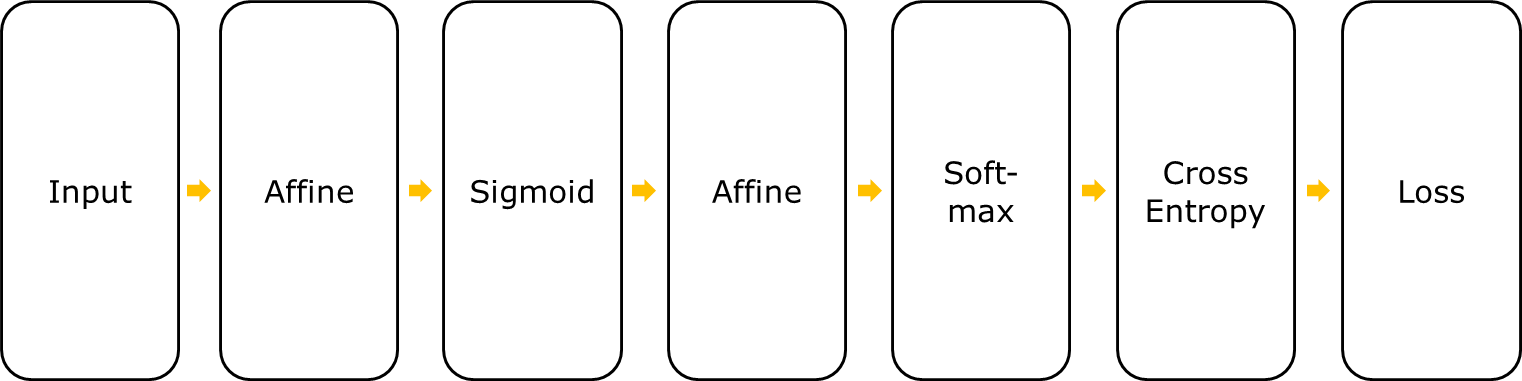

## 2. Pytorch로 구현하는 MNIST 손글씨 분류기
---
우리는 위에서 Numpy로 모델을 구현했습니다.  
Imput부터 Loss를 출력하는 부분까지 구현했었죠.  
이제는 Pytorch로 전체적인 흐름을 새로 만들어보겠습니다.  
Pytorch로 새로 구현해보는 만큼 데이터셋도 Pytorch에서 제공하는 코드들을 활용하여 다시 받아보도록 하겠습니다.  
마치 Keras에서 데이터를 받는 것 처럼요!

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn    # 파이토치 모듈 중 모델 설계할때 필요한 함수들 
import torch.nn.functional as F # 토치.nn 에서 가장 많이 쓰는 함수들
from torchvision import transforms, datasets

In [24]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using Pytorchversion:', torch.__version__,'\n','Device:,', DEVICE)

Using Pytorchversion: 1.9.0+cu102 
 Device:, cuda


In [25]:
BATCH_SIZE = 32
EPOCHS = 10

In [26]:
train_dataset = datasets.MNIST(root = '../data/MNIST', # 데이터 저장될장소 
                               train = True, # train인지test인지 
                               download = True,# 인터넷에서 다운로드해 이용할건지 
                               transform = transforms.ToTensor()) #이미지를 tensor 형태로 변환
                                                                  #0~255 를 0~1로 정규화까지 해줌

test_dataset = datasets.MNIST(root = '../data/MNIST',
                               train = False,
                               download = True,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

# mini-batch 단위(BATCH-SIZE)로 분리해서 지정 
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**🔎 torchvision에서 활용할 수 있는 dataset은 어떤게 있나요? ([torchvision 공식문서](https://pytorch.org/vision/stable/datasets.html)를 활용하여 2개이상 적어주세요.)**  
- CIFAR
- COCO
- Fashion-MNIST
- ImageNet
- KITTI
- MNIST
- VOC

**🔎 torch.utils.data.DataLoader()에는 어떤 기능이 있나요? 알고있는 만큼 적어주세요.**   
- `batch_size`
- `shuffle`
- `drop_last` : default - `False`
- `num_worker` : default - `0`(data will be laoded in the main process)


🔔 [Hint](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

In [27]:
class Net(nn.Module):## nn.Module 상속 
  def __init__(self):
    super(Net, self).__init__() ## nn.Module 의 init 상속
    self.fc1 = nn.Linear(28 * 28, 256) # input , output 
    self.fc2 = nn.Linear(256,10)
    # 층을 쌓고 
  def forward(self, x): # 쌓은 층에 대해서 Forward Propagation 정의(output 까진의 계산과정 나열)
    x = x.view(-1 , 28 * 28) # 1차원 데이터로 Flatten
    x = self.fc1(x) # fc1에 입력 
    x = F.sigmoid(x) # 그 아웃풋에 sigmoid 적용 
    x = self.fc2(x) # fc2에 입력 
    x = F.log_softmax(x, dim = 1) # 그 아웃풋에 log_softmax 적용 
                                  # 일반 softmax보다 더 그라디언트 계산이 쉽다고 함 
    return x

**🔎 Numpy로 구현된 분류기와 비교했을때 어떤부분이 바뀌었나요?**  
- `backward` 부분이 없다.

In [28]:
model = Net().to(DEVICE) # 상속했으니깐 Net()에서 to() 메서드를 쓸수있음 DEVICE로 보냄 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
critertion = nn.CrossEntropyLoss() # Loss 기준은 CrossEntropyLoss로 

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


**🔎 torch.optim에는 어떤 optimizer들을 구현할 수 있나요? ([공식 document](https://pytorch.org/docs/stable/optim.html?highlight=optim#module-torch.optim)를 참조하여 2개 이상 적어주세요.)**  
- `SGD`
- `Adam`
- `RMSprop`

**🔎 nn.Module에서 활용할 수 있는 Loss function에는 어떤 것들이 구현할 수 있나요? ([공식 document-Loss function](https://pytorch.org/docs/stable/nn.html?highlight=loss#loss-functions)를 참조하여 2개 이상 적어주세요.)**  
- `nn.MSELoss` : mean square error
- `nn.CrossEntropyLoss`
- `nn.BCELoss`: Binary Cross Entropy

In [29]:
def train(model, train_loader, optimizer, log_interval):
  model.train() # model을 train 상태로 지정 
  correct = 0
  for batch_idx , (image, label ) in enumerate(train_loader): # train_loader에 mini-batch단위로 지정된 데이터를학습
      image = image.to(DEVICE) # DEVICE에 할당
      label = label.to(DEVICE) # DEVICE에 할당

      optimizer.zero_grad() # 이전 이미지, 라벨 데이터로 게산된 LOSS의 그라디언트가 남아잇으니 초기화
      output = model(image) # input 을 모델에 넣어 output 계산 
      
      loss = critertion(output, label) # 계산된 output과 label의 loss를 계산함

      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
      
      loss.backward() #게산된 loss를 바탕으로 back propagation을 통해 계산된 그라디언트값을 각 파라미터에 할당 
      optimizer.step() # 그라디언트 값을 이용하여 파라미터 값을 업데이트 
      accuracy = 100. * correct / len(train_loader.dataset)

      if batch_idx % log_interval == 0:
        print(f'Train Epoch: {Epoch} [{batch_idx * len(image)} / {len(train_loader.dataset)}]')
        print(f'Train Loss: {loss.item():.4f}')
        print(f'Train Accuracy: {accuracy:.2f}')

In [30]:
def evaluate(model, test_loader):
  model.eval() # 모델을 평가상태(test 상태)로 지정 
  test_loss = 0 # test_loss 초기값 
  correct = 0 # 올바른 class로 분류한 카운트를 세기위해 0으로 설정 

  with torch.no_grad(): # 평가시에는 gradiant를 통해 패러미터 업데이트를 하지않음 
    for image, label in test_loader: # mini_batch 단위로 꺼내기 
      image = image.to(DEVICE) # DEVICE 할당
      label = label.to(DEVICE) # DEVICE에 할당
      output = model(image)    # 모델에 input을 넣어 output 계산 
      
      test_loss += critertion(output, label).item() # output과 label의 loss 계산 
      prediction = output.max(1, keepdim = True)[1] # output은 길이가 10인 벡터값 
                                                    # 그중에서 가장 큰값인 위치의 라벨로
                                                    # 예측햇다고 판단 
      correct += prediction.eq(label.view_as(prediction)).sum().item() # eq() 메서드는 라벨과 예측이 같으면(equal) 1
                                                                        # 다르면 0. 그 값들을더해서 correct에 더해주기 
  
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

**🔎 Autograd 패키지는 어떤 기능을 하나요? 아는만큼 적어주세요.**  

> Autograd is now a core torch package for automatic differentiation.
It uses a tape based system for automatic differentiation.
In the forward phase, the autograd tape will remember all the operations
it executed, and in the backward phase, it will replay the operations.

Autograd는 자동 미분을 수행하는 torch의 핵심 패키지로 미분을 위해 테잎(tape) 기반 시스템을 사용한다. 

**순전파(forward)** 단계에서 autograd 테잎은 수행하는 모든 연산을 기억한다. 그리고 **역전파(backward)** 단계에서 연산들을 재생(replay) 한다.

Augograd를 사용하면 backpropagation을 위한 미분 값을 자동으로 계산해준다. 자동 계산을 위해서는 사용하는 변수는 `torch.autograd`에 있는 `Variable`이라는 것을 사용해야 한다. 

- `data` : tensor 형태의 데이터
- `grad` : `data`가 거쳐온 layer에 대한 미분값 축적
- `grad_fn` : 미분값을 계산한 함수에 대한 정보



- https://pytorch.org/tutorials/beginner/former_torchies/autograd_tutorial_old.html?highlight=autograd
- https://do-hansung.tistory.com/16

🔔 [Hint](http://taewan.kim/trans/pytorch/tutorial/blits/02_autograd/)

In [31]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval= 200) # 아까 정의한 train 함수 실행, log_interval로 log가 뜨는 간격 설정 
  test_loss, test_accuracy = evaluate(model, test_loader) # 학습한 모델 test
  print(f'\n EPOCH: {Epoch}, \t Test Loss: {test_loss:.4f}, \t Test Accuracy: {test_accuracy:.2f} \n')

Train Epoch: 1 [0 / 60000]
Train Loss: 2.3170
Train Accuracy: 0.01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [6400 / 60000]
Train Loss: 2.2212
Train Accuracy: 2.31
Train Epoch: 1 [12800 / 60000]
Train Loss: 2.0229
Train Accuracy: 7.21
Train Epoch: 1 [19200 / 60000]
Train Loss: 1.6667
Train Accuracy: 13.57
Train Epoch: 1 [25600 / 60000]
Train Loss: 1.3885
Train Accuracy: 20.72
Train Epoch: 1 [32000 / 60000]
Train Loss: 1.1950
Train Accuracy: 28.50
Train Epoch: 1 [38400 / 60000]
Train Loss: 0.9741
Train Accuracy: 36.80
Train Epoch: 1 [44800 / 60000]
Train Loss: 0.7757
Train Accuracy: 45.32
Train Epoch: 1 [51200 / 60000]
Train Loss: 0.7318
Train Accuracy: 54.02
Train Epoch: 1 [57600 / 60000]
Train Loss: 0.6912
Train Accuracy: 62.88

 EPOCH: 1, 	 Test Loss: 0.0212, 	 Test Accuracy: 84.84 

Train Epoch: 2 [0 / 60000]
Train Loss: 0.5071
Train Accuracy: 0.05
Train Epoch: 2 [6400 / 60000]
Train Loss: 0.6233
Train Accuracy: 9.04
Train Epoch: 2 [12800 / 60000]
Train Loss: 0.7225
Train Accuracy: 18.12
Train Epoch: 2 [19200 / 60000]
Train Loss: 0.5354
Train Accuracy: 27.29
Train Epoch: 2 [

단 10 Epoch만에 Test Accuracy 91.96%를 달성했습니다!  
**Numpy로 구현된 모델의 결과와 Pytorch로 구현된 결과가 상이한 이유는 뭘까요?**  
주말동안 고민해보시고 다음주 월요일 풀잎시간에 얘기해보면 좋을 것 같습니다.